In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 635.4 kB/s eta 0:00:00


In [3]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

In [60]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/PTTK/VCB.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Use the correct format
df.set_index('Date', inplace=True)
df = df.dropna()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-04,23277.0,23600.0,23708.0,22953.0,1.31M,0.0
2016-01-05,22899.0,23115.0,23384.0,22846.0,1.95M,0.0
2016-01-06,23169.0,22899.0,23277.0,22899.0,1.20M,0.0
2016-01-07,22899.0,23061.0,23115.0,22630.0,1.61M,0.0
2016-01-08,22738.0,22792.0,22953.0,22468.0,1.17M,0.0
...,...,...,...,...,...,...
2023-12-21,80900.0,81000.0,81000.0,80300.0,2.03M,0.0
2023-12-22,80900.0,80900.0,81100.0,80400.0,1.58M,0.0
2023-12-25,81800.0,80900.0,81800.0,80700.0,1.30M,0.0


In [6]:
#RATIO 7:3

In [61]:
# split data ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:train_size73+test_size73]

In [62]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data73['Price'], nlags= 700)

In [63]:
# training 7:3
y_train73 = np.array(train_data73['Price'])

x_train73 = []
for data in train_data73['High']:
  x_train73.append([data])

model73 = dlm(y_train73)
model73 = model73 + trend(1, discount=0.99, name='Trend', w=1e7)
model73 = model73 + dynamic(features=x_train73, discount=1, name='High')
model73 = model73 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model73 = model73 + longSeason(period=12, stay=30, data=y_train73, name='season', w=1e7)

model73.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [64]:
# testing 7:3
x_test73 = []
for data in test_data73['High']:
  x_test73.append([data])

y_test73 = np.array(test_data73['Price'])

y_pred73 = model73.predictN(date = model73.n-1, N=len(x_test73),featureDict={'High': x_test73})
y_pred73 = y_pred73[0]


In [65]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Assuming train_data73 is a DataFrame with 'Price' column and 'Date' as the index
# Make sure 'Date' is in datetime format
train_data73.index = pd.to_datetime(train_data73.index)

ln_model73 = LinearRegression()

# Use the datetime index for training
ln_model73.fit(np.arange(len(train_data73)).reshape(-1, 1), train_data73['High'])

# Predict the prices for the next 30 days
last_index73 = train_data73.index[-1]
next_30_days_indices73 = np.arange(len(train_data73), len(train_data73) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days73 = ln_model73.predict(next_30_days_indices73)

# Generate the next 30 days date indices
next_30_days_dates73 = pd.date_range(start=last_index73 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df73 = pd.DataFrame({'Date': next_30_days_dates73, 'Predicted_High': high_next_30_days73})
predicted_df73.set_index('Date', inplace=True)

print(predicted_df73)


            Predicted_High
Date                      
2021-08-06    78847.046389
2021-08-07    78890.612251
2021-08-08    78934.178113
2021-08-09    78977.743974
2021-08-10    79021.309836
2021-08-11    79064.875698
2021-08-12    79108.441560
2021-08-13    79152.007422
2021-08-14    79195.573284
2021-08-15    79239.139146
2021-08-16    79282.705007
2021-08-17    79326.270869
2021-08-18    79369.836731
2021-08-19    79413.402593
2021-08-20    79456.968455
2021-08-21    79500.534317
2021-08-22    79544.100179
2021-08-23    79587.666040
2021-08-24    79631.231902
2021-08-25    79674.797764
2021-08-26    79718.363626
2021-08-27    79761.929488
2021-08-28    79805.495350
2021-08-29    79849.061212
2021-08-30    79892.627073
2021-08-31    79936.192935
2021-09-01    79979.758797
2021-09-02    80023.324659
2021-09-03    80066.890521
2021-09-04    80110.456383


In [66]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo 7:3
x_next_30_days73 = []
for data in high_next_30_days73:
  x_next_30_days73.append([data])

y_next_30_days73 = model73.predictN(N = 30, featureDict={'High': x_next_30_days73})
y_next_30_days73 = y_next_30_days73[0]
print(y_next_30_days73)


[76843.03634724574, 77010.17290178704, 76986.4212886154, 77072.5959762808, 77107.24362146696, 77173.69894656533, 77223.27678981902, 77281.81325824559, 77335.22187006554, 77391.36425310349, 77446.0073506035, 77501.48061606656, 77556.50490480325, 77832.79561337017, 77880.57467427099, 77964.38120792352, 77999.13921424175, 78059.2946848235, 78109.29477274387, 78166.99980941502, 78221.01802410155, 78276.99808846631, 78331.79443968795, 78387.1907132559, 78442.25082187116, 78497.49824106548, 78552.64604509721, 78607.8493545603, 78663.02234631631, 78718.21181249389]


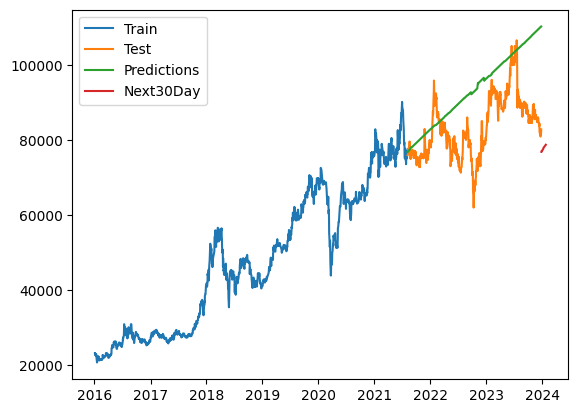

In [67]:
# Generating the next 30 days date indices
last_test_date73 = test_data73.index[-1]
next_30_days_dates73 = pd.date_range(start=last_test_date73 + pd.DateOffset(1), periods=30)

# 10. Vẽ hình 7:3
plt.plot(train_data73.index, train_data73['Price'])
plt.plot(test_data73.index, test_data73['Price'])
plt.plot(test_data73.index, y_pred73)
plt.plot(next_30_days_dates73,y_next_30_days73)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [13]:
#RATIO 8:2

In [68]:
# Split the data into training, testing, and validating sets
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:train_size82+test_size82]

In [69]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data82['Price'], nlags= 700)

In [70]:
# training
y_train82 = np.array(train_data82['Price'])

x_train82 = []
for data in train_data82['High']:
  x_train82.append([data])

model82 = dlm(y_train82)
model82 = model82 + trend(1, discount=0.99, name='Trend', w=1e7)
model82 = model82 + dynamic(features=x_train82, discount=1, name='High')
model82 = model82 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model82 = model82 + longSeason(period=12, stay=30, data=y_train82, name='season', w=1e7)

model82.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [71]:
# testing
x_test82= []
for data in test_data82['High']:
  x_test82.append([data])

y_test82 = np.array(test_data82['High'])

y_pred82 = model82.predictN(date = model82.n-1, N=len(x_test82),featureDict={'High': x_test82})
y_pred82 = y_pred82[0]


In [72]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data82.index = pd.to_datetime(train_data82.index)

ln_model82 = LinearRegression()

# Use the datetime index for training
ln_model82.fit(np.arange(len(train_data82)).reshape(-1, 1), train_data82['High'])

# Predict the prices for the next 30 days
last_index82 = train_data82.index[-1]
next_30_days_indices82 = np.arange(len(train_data82), len(train_data82) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days82 = ln_model82.predict(next_30_days_indices82)

# Generate the next 30 days date indices
next_30_days_dates82 = pd.date_range(start=last_index82 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df82 = pd.DataFrame({'Date': next_30_days_dates82, 'Predicted_High': high_next_30_days82})
predicted_df82.set_index('Date', inplace=True)

print(predicted_df82)


            Predicted_High
Date                      
2022-05-28    86291.709886
2022-05-29    86334.124310
2022-05-30    86376.538735
2022-05-31    86418.953159
2022-06-01    86461.367583
2022-06-02    86503.782008
2022-06-03    86546.196432
2022-06-04    86588.610856
2022-06-05    86631.025281
2022-06-06    86673.439705
2022-06-07    86715.854129
2022-06-08    86758.268554
2022-06-09    86800.682978
2022-06-10    86843.097402
2022-06-11    86885.511827
2022-06-12    86927.926251
2022-06-13    86970.340675
2022-06-14    87012.755100
2022-06-15    87055.169524
2022-06-16    87097.583948
2022-06-17    87139.998373
2022-06-18    87182.412797
2022-06-19    87224.827221
2022-06-20    87267.241646
2022-06-21    87309.656070
2022-06-22    87352.070494
2022-06-23    87394.484919
2022-06-24    87436.899343
2022-06-25    87479.313767
2022-06-26    87521.728192


In [73]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days82 = []
for data in high_next_30_days82:
  x_next_30_days82.append([data])

y_next_30_days82 = model82.predictN(N = 30, featureDict={'High': x_next_30_days82})
y_next_30_days82 = y_next_30_days82[0]
print(y_next_30_days82)


[77448.55658369215, 77444.4394232016, 77439.620064901, 77490.92119947005, 77549.65159996996, 77602.08318927164, 77648.95412552136, 77695.69074051031, 77743.57376670644, 77791.9658202108, 77840.25949952775, 77888.39814235308, 77936.50061963749, 77984.6272394604, 78032.7715125962, 78080.91667186632, 78129.05790197983, 78177.19744332926, 78225.3372926048, 78273.47766475694, 78321.61815962895, 78369.75857494483, 78417.89893074299, 78153.22629770805, 78182.8687740343, 78267.77246359769, 78344.23255300475, 78391.01214305342, 78432.8350602425, 78478.60216752856]


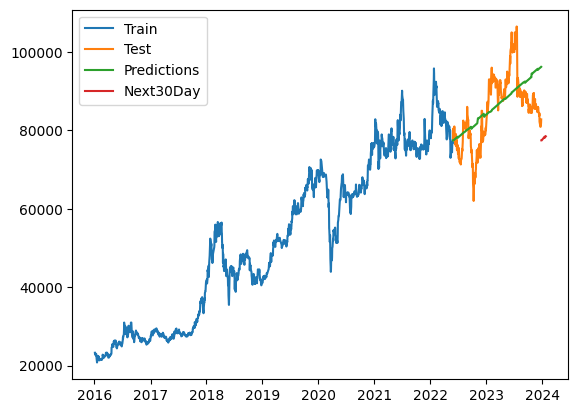

In [74]:
# Generating the next 30 days date indices
last_test_date82 = test_data82.index[-1]
next_30_days_dates82 = pd.date_range(start=last_test_date82 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data82.index, train_data82['Price'])
plt.plot(test_data82.index, test_data82['Price'])
plt.plot(test_data82.index, y_pred82)
plt.plot(next_30_days_dates82,y_next_30_days82)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [21]:
#RATIO 9:1

In [75]:
# Split the data into training, testing, and validating sets
train_size91 = int(0.9 * len(df))
test_size91 = int(0.1 * len(df))

train_data91 = df[:train_size91]
test_data91 = df[train_size91:train_size91+test_size91]

In [76]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data91['Price'], nlags= 700)

In [77]:
# 4. Quá trình training
y_train91 = np.array(train_data91['Price'])

x_train91 = []
for data in train_data91['High']:
  x_train91.append([data])

model91 = dlm(y_train91)
model91 = model91 + trend(1, discount=0.99, name='Trend', w=1e7)
model91 = model91 + dynamic(features=x_train91, discount=1, name='High')
model91 = model91 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model91 = model91 + longSeason(period=12, stay=30, data=y_train91, name='season', w=1e7)

model91.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [78]:
# 5. Quá trình testing
x_test91= []
for data in test_data91['High']:
  x_test91.append([data])

y_test91 = np.array(test_data91['Price'])

y_pred91 = model91.predictN(date = model91.n-1, N=len(x_test91),featureDict={'High': x_test91})
y_pred91 = y_pred91[0]


In [79]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data91.index = pd.to_datetime(train_data91.index)

ln_model91 = LinearRegression()

# Use the datetime index for training
ln_model91.fit(np.arange(len(train_data91)).reshape(-1, 1), train_data91['High'])

# Predict the prices for the next 30 days
last_index91 = train_data91.index[-1]
next_30_days_indices91 = np.arange(len(train_data91), len(train_data91) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days91 = ln_model91.predict(next_30_days_indices91)

# Generate the next 30 days date indices
next_30_days_dates91 = pd.date_range(start=last_index91 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df91 = pd.DataFrame({'Date': next_30_days_dates91, 'Predicted_High': high_next_30_days91})
predicted_df91.set_index('Date', inplace=True)

print(predicted_df91)


            Predicted_High
Date                      
2023-03-16    90852.025046
2023-03-17    90891.280040
2023-03-18    90930.535035
2023-03-19    90969.790029
2023-03-20    91009.045023
2023-03-21    91048.300017
2023-03-22    91087.555012
2023-03-23    91126.810006
2023-03-24    91166.065000
2023-03-25    91205.319995
2023-03-26    91244.574989
2023-03-27    91283.829983
2023-03-28    91323.084977
2023-03-29    91362.339972
2023-03-30    91401.594966
2023-03-31    91440.849960
2023-04-01    91480.104954
2023-04-02    91519.359949
2023-04-03    91558.614943
2023-04-04    91597.869937
2023-04-05    91637.124931
2023-04-06    91676.379926
2023-04-07    91715.634920
2023-04-08    91754.889914
2023-04-09    91794.144909
2023-04-10    91833.399903
2023-04-11    91872.654897
2023-04-12    91911.909891
2023-04-13    91951.164886
2023-04-14    91990.419880


In [80]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days91 = []
for data in high_next_30_days91:
  x_next_30_days91.append([data])

y_next_30_days91 = model91.predictN(N = 30, featureDict={'High': x_next_30_days91})
y_next_30_days91 = y_next_30_days91[0]
print(y_next_30_days91)


[91467.82169296182, 91551.40342556061, 91592.12745418896, 93349.3893075314, 93450.80005147065, 93552.8074755666, 93543.6637881972, 93593.89801641383, 93642.76183033797, 93697.44801848491, 93750.02157321363, 93802.74707054936, 93855.19780006412, 93907.72457797374, 93960.24018462341, 94012.76797953542, 94065.2929456704, 94117.81859109557, 94170.34371650402, 94222.86895252772, 94275.3941516039, 94327.9193723501, 94380.44458852039, 94432.96980655825, 94485.4950237037, 94538.02024104803, 94590.54545830266, 94643.07067559398, 94695.59589287634, 94748.12111016284]


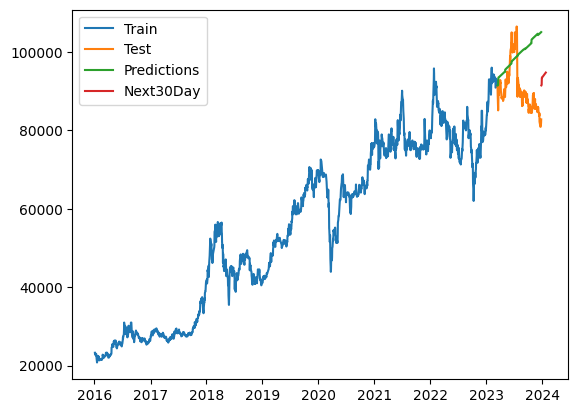

In [81]:
# Generating the next 30 days date indices
last_test_date91 = test_data91.index[-1]
next_30_days_dates91 = pd.date_range(start=last_test_date91 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data91.index, train_data91['Price'])
plt.plot(test_data91.index, test_data91['Price'])
plt.plot(test_data91.index, y_pred91)
plt.plot(next_30_days_dates91,y_next_30_days91)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [29]:
#ACCURACY EVALUATION

In [82]:
#method to calculate mape
def calc_mape(actual, predicted):

    # Convert to numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate absolute percentage error
    absolute_error = np.abs((actual - predicted) / actual)

    # Handle division by zero cases
    absolute_error[np.isinf(absolute_error)] = 0.0

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_error) * 100

    return mape

In [83]:
#accuracy evaluate 7:3
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse73 = np.sqrt(np.mean((y_pred73 - y_test73)**2))
test_mape73 = calc_mape(y_test73, y_pred73)
test_msle73 = msle(y_test73, y_pred73)

print(test_rmse73)
print(test_mape73)
print(test_msle73)

13156.830661578986
13.33631238113631
0.021877628996085995


In [84]:
#accuracy evaluate 8:2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse82 = np.sqrt(np.mean((y_pred82 - y_test82)**2))
test_mape82 = calc_mape(y_test82, y_pred82)
test_msle82 = msle(y_test82, y_pred82)

print(test_rmse82)
print(test_mape82)
print(test_msle82)

7118.159604235095
6.8178408413425595
0.006637099152509802


In [85]:
#accuracy evaluate 9:1
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle

test_rmse91 = np.sqrt(np.mean((y_pred91 - y_test91)**2))
test_mape91 = calc_mape(y_test91, y_pred91)
test_msle91 = msle(y_test91, y_pred91)

print(test_rmse91)
print(test_mape91)
print(test_msle91)


11945.33764556218
11.444445812194916
0.01608352524717106
